# Regional Analysis

This notebook evaluates how the DSW formation and its shelf overflow plume responds to the thickening of the surface cell of the model. The thickness of the uppemost cell only was increased between runs here, from 1m thick to 5m thick. The comparisson is done using two models - MOM5 and MOM6

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from dask.distributed import Client
import cftime
from datetime import timedelta
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1, sigma2
import matplotlib.path as mpath

import matplotlib.pyplot as plt
import cmocean.cm as cmo

In [2]:
client = Client(n_workers = 48, memory_limit = '1350gb')

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22358584366912 and this is thread id 22357339842304.
Exception closing connection <sqlite3.Connection object at 0x14523e733640>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/sit

# Set up

# Part 1 : Importing data

### 1.1 SWMT between runs

#### Importing MOM6

In [3]:
import glob
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/sigma0_panan01/*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
P01_1dz=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


10 netcdf data files


In [4]:
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/sigma0_panan01_5mtop/*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
P01_5dz=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


10 netcdf data files


In [5]:
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/sigma0_panan01_5m_weakwinds/*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
P01_5dz_weakwinds=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


9 netcdf data files


#### Separating shelf

In [6]:
def shelf_mask_isobath(var, contour_depth, resolution, output_mask=False):
    '''
    Masks variales by the region polewards of a given isobath
    '''
    
    ds_contour = xr.open_dataset(
        '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
        'Antarctic_slope_contour_' + str(contour_depth) + 'm_MOM6_' +
        resolution + 'deg.nc')
    
    shelf_mask = ds_contour.contour_masked_above.sel(yh=slice(var.yh[0], var.yh[-1]))
    yh = ds_contour.yh.sel(yh=slice(var.yh[0], var.yh[-1]))
    xh = ds_contour.xh
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask = shelf_mask.where(shelf_mask == 0)+1
    shelf_mask = shelf_mask.where(shelf_mask == 1, 0)
    
    # multiply the variable with the mask
    masked_var = var * shelf_mask
    
    if output_mask == True:
        return masked_var, shelf_mask
    else:
        return masked_var

In [7]:
SHeat_5dz_shelf, shelf_mask_MOM6 = shelf_mask_isobath(P01_5dz.binned_heat_transformation, 1000, '01', output_mask=True)
Ssalt_5dz_shelf = shelf_mask_isobath(P01_5dz.binned_salt_transformation, 1000, '01')


SHeat_5dz_shelf_weakwinds = shelf_mask_isobath(P01_5dz_weakwinds.binned_heat_transformation, 1000, '01')
Ssalt_5dz_shelf_weakwinds = shelf_mask_isobath(P01_5dz_weakwinds.binned_salt_transformation, 1000, '01')

SHeat_1dz_shelf = shelf_mask_isobath(P01_1dz.binned_heat_transformation, 1000, '01')
Ssalt_1dz_shelf = shelf_mask_isobath(P01_1dz.binned_salt_transformation, 1000, '01')

ShelfWMT_1dz_3d = shelf_mask_isobath(Ssalt_1dz_shelf+SHeat_1dz_shelf,1000, '01')

In [8]:
ShelfWMT_5dz = (SHeat_5dz_shelf+Ssalt_5dz_shelf).sum('xh').sum('yh')
ShelfWMT_5dz_weakwinds = (SHeat_5dz_shelf_weakwinds+Ssalt_5dz_shelf_weakwinds).sum('xh').sum('yh')
ShelfWMT_1dz = (SHeat_1dz_shelf+Ssalt_1dz_shelf).sum('xh').sum('yh')

In [9]:
ShelfWMT_5dz_cumsum = (SHeat_5dz_shelf+Ssalt_5dz_shelf).cumsum('xh').sum('yh')
ShelfWMT_1dz_cumsum = (SHeat_1dz_shelf+Ssalt_1dz_shelf).cumsum('xh').sum('yh')

In [10]:
#defining multiline plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [11]:
isopycnal_bin_midy=np.tile(ShelfWMT_5dz.isopycnal_bins,(10,1))
np.shape(isopycnal_bin_midy)


isopycnal_bin_midy2=np.tile(ShelfWMT_1dz.isopycnal_bins,(10,1))

#### Importing MOM5

In [12]:
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/01deg_jra55v13_ryf9091_21mbath/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
c21mbath=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


10 netcdf data files


In [13]:
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/ryf_5mtoponly/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
r5mtop=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


10 netcdf data files


In [14]:
#FWFDist
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/ryf_FWFdist/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
FWFdist=xr.open_mfdataset(gl, concat_dim='time',combine='nested')

10 netcdf data files


In [15]:
#Halfmtop
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/ryf_halfmtop/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
ryf_halfmtop=xr.open_mfdataset(gl, concat_dim='time',combine='nested')

10 netcdf data files


In [16]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map

In [17]:
session = cc.database.create_session()
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091', 'area_t', session, n=1) # needed for the plots I'll provide.

In [18]:
#masking outside the shelf
swmt21mbath_shelf, shelf_mask = shelf_mask_isobath(c21mbath.surface_water_mass_transformation)
swmt5mtop_shelf, shelf_mask = shelf_mask_isobath(r5mtop.surface_water_mass_transformation)
swmtFWFdist_shelf, shelf_mask = shelf_mask_isobath(FWFdist.surface_water_mass_transformation)
swmthalfMtop_shelf, shelf_mask = shelf_mask_isobath(ryf_halfmtop.surface_water_mass_transformation)
areat_shelf, shelf_mask = shelf_mask_isobath(area_t)

#multiplying SWMT by area to get m3/s
swmt21mbath_sum = (swmt21mbath_shelf * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).load()
swmt5mtop_sum = (swmt5mtop_shelf * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).load()
swmtFWFdist_sum = (swmtFWFdist_shelf * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).load()
swmthalfMtop_sum = (swmthalfMtop_shelf * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).load()

In [19]:
#multiplying SWMT by area to get m3/s
swmt21mbath_ysum = (swmt21mbath_shelf * area_t / 1e6).sum(['yt_ocean']).load()
swmt5mtop_ysum = (swmt5mtop_shelf * area_t / 1e6).sum(['yt_ocean']).load()
swmtFWFdist_ysum = (swmtFWFdist_shelf * area_t / 1e6).sum(['yt_ocean']).load()
swmthalfMtop_ysum = (swmthalfMtop_shelf * area_t / 1e6).sum(['yt_ocean']).load()

In [20]:
#multiplying SWMT by area to get m3/s
swmt21mbath_cumsum = (swmt21mbath_shelf * area_t / 1e6).sum(['yt_ocean']).cumsum(['xt_ocean']).load()
swmt5mtop_cumsum = (swmt5mtop_shelf * area_t / 1e6).sum(['yt_ocean']).cumsum(['xt_ocean']).load()
swmtFWFdist_cumsum = (swmtFWFdist_shelf * area_t / 1e6).sum(['yt_ocean']).cumsum(['xt_ocean']).load()
swmthalfMtop_cumsum = (swmthalfMtop_shelf * area_t / 1e6).sum(['yt_ocean']).cumsum(['xt_ocean']).load()

In [21]:
isopycnal_bin_midmom5_ctrl=np.tile(swmt21mbath_shelf.isopycnal_bins,(10,1))
isopycnal_bin_midmom5_5mtop=np.tile(swmt5mtop_shelf.isopycnal_bins,(10,1))
isopycnal_bin_midmom5_FWFdist=np.tile(swmtFWFdist_shelf.isopycnal_bins,(10,1))
isopycnal_bin_midmom5_halfMtop=np.tile(swmthalfMtop_shelf.isopycnal_bins,(3,1))

In [22]:
swmt21mbath_sum['time']=ShelfWMT_1dz.time
swmt5mtop_sum['time']=ShelfWMT_1dz.time
swmtFWFdist_sum['time']=ShelfWMT_1dz.time
swmthalfMtop_sum['time']=ShelfWMT_1dz.time

In [23]:
figpath='/g/data/ik11/users/wf4500/DSW_collaborative/sigma0_SWMT/figs/'

### 1.2 Volume transport accross the 1km isobath

#### Importing MOM6

In [24]:
#Overflow files for panan01

#full file
Overflow_P5mtop= xr.open_mfdataset('/home/156/wf4500/v45_wf4500/DSW_collaborative/Daily_mass_transports/panan01_5mtop/*')
Overflow_P1mtop= xr.open_mfdataset('/g/data/e14/cs6673/mom6_comparison/data_DSW/vol_transp_across_1000m_isobath_panan_01deg_jra55_ryf_1m_*')
#contour sum, yearly mean
Overflowsum_P5mtop=Overflow_P5mtop.sum('contour_index').groupby('time.year').mean().isel(rho2_l=slice(None, None, -1))
Overflowsum_P1mtop=Overflow_P1mtop.sum('contour_index').isel(time=slice(0,120)).groupby('time.year').mean().isel(rho2_l=slice(None, None, -1))

In [25]:
P1rho = np.tile(Overflowsum_P1mtop.rho2_l,[10,1])
P5rho = np.tile(Overflowsum_P5mtop.rho2_l,[9,1])


In [26]:
Overflowsum_P5mtop_cumsum=Overflow_P5mtop.sum('contour_index').groupby('time.year').mean().isel(rho2_l=slice(None, None, -1))
Overflowsum_P1mtop_cumsum=Overflow_P1mtop.sum('contour_index').isel(time=slice(0,120)).groupby('time.year').mean().isel(rho2_l=slice(None, None, -1))

#### Importing MOM5

In [27]:
basedir='/home/156/wf4500/v45_wf4500/DSW_collaborative/Daily_mass_transports'

#OM2_21mbath (1mtop
gl =sorted(glob.glob(basedir + "/01deg_jra55v13_ryf9091_21mbath/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=Overflow_P1mtop.time[:120]
OM2_21mbath_voltrans=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans

#OM2_5mtop (5mtop)
gl =sorted(glob.glob(basedir + "/01deg_jra55v13_ryf9091_21mbath_5mtop/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=Overflow_P1mtop.time[:120]
OM2_5mtop_voltrans=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans

#OM2_FWFdist 
gl =sorted(glob.glob(basedir + "/ryf_FWFdist/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=Overflow_P1mtop.time[:120]
OM2_FWFdist_voltrans=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans



#OM2_halmtop (halfmtop)
gl =sorted(glob.glob(basedir + "/01deg_jra55v13_ryf9091_21mbath_halfmtop/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested').isel(time=slice(0,120))
expt0_voltrans['time']=Overflow_P1mtop.time[:120]
OM2_halfMtop_voltrans=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans


In [28]:
# The sum of overflow will be
Overflowsum_OM5mtop=OM2_5mtop_voltrans.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_OM1mtop=OM2_21mbath_voltrans.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_FWFdist=OM2_FWFdist_voltrans.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_OMhalfMtop=OM2_halfMtop_voltrans.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))

In [29]:
OM1rho = np.tile(Overflowsum_OM1mtop.isopycnal_bins,[10,1])
OM5rho = np.tile(Overflowsum_OM5mtop.isopycnal_bins,[10,1])
FWFdistrho = np.tile(Overflowsum_FWFdist.isopycnal_bins,[10,1])
OMHalfrho = np.tile(Overflowsum_OMhalfMtop.isopycnal_bins,[10,1])

In [30]:
# The sum of overflow will be
Overflowsum_OM5mtop_cumsum = OM2_5mtop_voltrans.cumsum('contour_index').isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_OM1mtop_cumsum = OM2_21mbath_voltrans.cumsum('contour_index').isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_OMhalfMtop_cumsum = OM2_halfMtop_voltrans.cumsum('contour_index').isel(isopycnal_bins=slice(None, None, -1))

In [31]:
# The sum of overflow will be
Overflowsum_OM5mtop_nosum = OM2_5mtop_voltrans.isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_OM1mtop_nosum = OM2_21mbath_voltrans.isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_OMhalfMtop_nosum = OM2_halfMtop_voltrans.isel(isopycnal_bins=slice(None, None, -1))

### 1.3 Circumpolar densities

In [32]:
gdata_db='/home/156/wf4500/databases/access/DSW.db'
temporary_db='/home/156/wf4500/databases/access/temporary_DSW.db'

temp_session = cc.database.create_session(temporary_db)
session = cc.database.create_session()

start_time='1908-01'
end_time='1910-12'
time_slice=slice(start_time,end_time)
lat_slice=slice(-90,-55)

start_timeMOM6='1997-01'
end_timeMOM6='1999-12'
time_sliceMOM6=slice(start_timeMOM6,end_timeMOM6)

In [33]:
#last may densities
#MOM5
σ0_OM2_1m_winter = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'pot_rho_0', session, start_time=start_time,\
                               end_time=end_time,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_slice).sel(yt_ocean=lat_slice).isel(time=25).load()




#MOM6
σ0_MOM6_1m_winter = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'rhopot2', session, start_time=start_timeMOM6,\
                               end_time=end_timeMOM6,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_sliceMOM6).sel(yh=lat_slice).isel(time=25).load()
σ0_MOM6_1m_winter.time

<xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(1999, 2, 15, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 8B 1999-02-15 00:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP
    bounds:         time_bnds

In [34]:
tarea = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'area_t', session, n=1)
areacello = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'areacello',session,n=1)

#MOM5
σ0_OM2_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'pot_rho_0', session, start_time=start_time,\
                               end_time=end_time,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_slice).mean('time').sel(yt_ocean=lat_slice)

σ0_OM2_5m  = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'pot_rho_0', session, start_time=start_time,\
                                end_time=end_time,frequency='1 monthly',chunks= {"time":  '200MB'})\
.sel(time=time_slice).mean('time').sel(yt_ocean=lat_slice)



#MOM6
σ0_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'rhopot2', session, start_time=start_timeMOM6,\
                               end_time=end_timeMOM6,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_sliceMOM6).mean('time').sel(yh=lat_slice)

σ0_MOM6_5m  = cc.querying.getvar('mom6-panan', 'rhopot2', temp_session, start_time=start_timeMOM6,\
                                end_time=end_timeMOM6,frequency='1 monthly',chunks= {"time":  '200MB'})\
.sel(time=time_sliceMOM6).mean('time').sel(yh=lat_slice)


In [35]:
%%time
#doing the zonal means
#MOM5
σ0_OM2_1m_zm=σ0_OM2_1m.weighted(tarea.fillna(0)).mean('xt_ocean').load()
σ0_OM2_5m_zm=σ0_OM2_5m.weighted(tarea.fillna(0)).mean('xt_ocean').load()
#MOM6
σ0_MOM6_1m_zm=σ0_MOM6_1m.weighted(areacello.fillna(0)).mean('xh').load()
σ0_MOM6_5m_zm=σ0_MOM6_5m.weighted(areacello.fillna(0)).mean('xh').load()

CPU times: user 40.9 s, sys: 5.43 s, total: 46.3 s
Wall time: 52.1 s


Importing age at the bottom

In [36]:
################# MOM5 ####################################
age_OM2_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'age_global', session, start_time=start_time,\
                               end_time=end_time,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_slice).isel(time=slice(24,36)).mean('time').sel(yt_ocean=slice(-90,-50))

# Separating the age at the bottom 
depth_array_1m = age_OM2_1m * 0 + age_OM2_1m.st_ocean
max_depth = depth_array_1m.max(dim = 'st_ocean', skipna= True)
ageob_OM2_1m = age_OM2_1m.where(depth_array_1m.st_ocean >= max_depth)
ageob_OM2_1m = ageob_OM2_1m.sum(dim = 'st_ocean')




################# MOM6 ####################################
age_MOM6_1m = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'agessc', session, start_time=start_timeMOM6,\
                               end_time=end_timeMOM6,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_sliceMOM6).isel(time=slice(24,36)).mean('time').sel(yh=slice(-90,-50))


# Separating the age at the bottom 
del depth_array_1m
depth_array_1m = age_MOM6_1m * 0 + age_MOM6_1m.z_l
max_depth = depth_array_1m.max(dim = 'z_l', skipna= True)
ageob_MOM6_1m = age_MOM6_1m.where(depth_array_1m.z_l >= max_depth)
ageob_MOM6_1m = ageob_MOM6_1m.sum(dim = 'z_l')

In [37]:
ageob_OM2_1m.load()
ageob_MOM6_1m.load()
print('age loaded')

age loaded


In [38]:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ht = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', session, n=1).sel(yt_ocean=lat_slice)
ht_50S = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', session, n=1).sel(yt_ocean=slice(-90,-50)).load()
deptho = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'deptho', session, n=1).sel(yh=slice(-90,-50)).load()
land_mask = (ht*0).fillna(1)

In [39]:
swmt21mbath_shelf_spatialplot=(swmt21mbath_shelf.mean('time') * area_t).load() #m3/s
ShelfWMT_1dz_spatialplot = ShelfWMT_1dz_3d.mean('time').load()
shelf_mask_off = shelf_mask.where(shelf_mask<1)+1
shelf_mask_MOM6_nan = shelf_mask_MOM6.where(shelf_mask_MOM6>0)
shelf_mask_off_MOM6 = shelf_mask_MOM6.where(shelf_mask_MOM6<1)+1
#ageob_OM2_1m_offshelf = shelf_mask_off*ageob_OM2_1m
ageob_OM2_1m_offshelf = ageob_OM2_1m.where(ht_50S.fillna(0)>1000)
# ageob_MOM6_1m_offshelf = shelf_mask_off_MOM6*ageob_MOM6_1m
ageob_MOM6_1m_offshelf = ageob_MOM6_1m.where(deptho.fillna(0)>1000)

Transformation of densities fields to be a function of distance to the coast in degrees

In [40]:
# Find the index of the first 0 value in each column of xt_ocean
def find_first_zero_index(shelf_mask):
    # Initialize an array to store the indices
    first_zero_indices = np.full(shelf_mask.shape[1], -1)

    # Iterate over each column (xt_ocean)
    for xt in range(shelf_mask.shape[1]):
        # Find the indices of all 0s in the current column
        zero_indices = np.where(shelf_mask[:, xt] == 0)[0]
        
        # If there are any 1s, take the last one
        if zero_indices.size > 0:
            first_zero_indices[xt] = zero_indices[0]
    
    return first_zero_indices


# Find the index of the last 1 value in each column of xt_ocean
def find_last_zero_index(shelf_mask):
    # Initialize an array to store the indices
    last_zero_indices = np.full(shelf_mask.shape[1], -1)

    # Iterate over each column (xt_ocean)
    for xt in range(shelf_mask.shape[1]):
        # Find the indices of all 0s in the current column
        zero_indices = np.where(shelf_mask[:, xt] == 1)[0]
        
        # If there are any 1s, take the last one
        if zero_indices.size > 0:
            last_zero_indices[xt] = zero_indices[-1]
    
    return last_zero_indices



In [41]:
# Apply the function to the shelf_mask
first_zero_indices_om2 = find_first_zero_index(shelf_mask)
last_zero_indices_om2 = find_last_zero_index(shelf_mask)

first_zero_indices_MOM6 = find_first_zero_index(shelf_mask_MOM6)
last_zero_indices_MOM6 = find_last_zero_index(shelf_mask_MOM6)

#getting the latitude coodinate for extraction
yt_ocean_om2 = σ0_OM2_1m.yt_ocean
yh_ocean_MOM6 = shelf_mask_MOM6.yh

In [42]:
#for OM2

# Create a new yt_ocean coordinate array for temp
new_yt_ocean_coords_om2 = np.empty((584, 3600))
for xt, idx in enumerate(last_zero_indices_om2):
    if idx != -1:  # Make sure there was a 0 in this xt_ocean column
        offset = σ0_OM2_1m.coords["yt_ocean"].values[idx]
        new_yt_ocean_coords_om2 [:, xt] = σ0_OM2_1m.coords["yt_ocean"].values - offset
        
        

# Assign the new yt_ocean coordinates to the temp xarray
new_yt_ocean_coords_da_om2 = xr.DataArray(new_yt_ocean_coords_om2, dims=["yt_ocean", "xt_ocean"],coords = [σ0_OM2_1m.yt_ocean, σ0_OM2_1m.xt_ocean])

new_coord_om2 = np.zeros((75,584,3600))
for i in range(75):
    new_coord_om2[i,:,:] = new_yt_ocean_coords_om2

new_coord_om2 = xr.DataArray(new_coord_om2, dims = ['st_ocean','yt_ocean','xt_ocean'], coords = [σ0_OM2_1m.st_ocean, σ0_OM2_1m.yt_ocean,σ0_OM2_1m.xt_ocean])


In [43]:
# for MOM6

# Create a new yt_ocean coordinate array for temp
new_yt_ocean_coords_MOM6 = np.empty((460, 3600))
for xt, idx in enumerate(last_zero_indices_MOM6):
    if idx != -1:  # Make sure there was a 0 in this xt_ocean column
        offset = σ0_MOM6_1m.sel(yh=slice(shelf_mask_MOM6.yh.min(),shelf_mask_MOM6.yh.max())).coords["yh"].values[idx]
        new_yt_ocean_coords_MOM6 [:, xt] =  σ0_MOM6_1m.sel(yh=slice(shelf_mask_MOM6.yh.min(),shelf_mask_MOM6.yh.max())).coords["yh"].values - offset


# Assign the new yt_ocean coordinates to the temp xarray
new_yt_ocean_coords_da_MOM6 = xr.DataArray(new_yt_ocean_coords_MOM6, dims=["yh", "xh"],coords = [shelf_mask_MOM6.yh, σ0_MOM6_1m.xh])

new_coord_MOM6 = np.zeros((75,460,3600))
for i in range(75):
    new_coord_MOM6[i,:,:] = new_yt_ocean_coords_MOM6

new_coord_MOM6 = xr.DataArray(new_coord_MOM6, dims = ['z_l','yh','xh'], coords = [σ0_MOM6_1m.z_l, shelf_mask_MOM6.yh, σ0_MOM6_1m.xh])


In [44]:
#saving it
file_path = '/g/data/v45/wf4500/DSW_collaborative/Additional_data/'

# Save the DataArray to NetCDF
new_coord_om2.to_netcdf(file_path + 'lat_to_shelf_bin_om2.nc')
new_coord_MOM6.to_netcdf(file_path + 'lat_to_shelf_bin_MOM6.nc')

In [45]:
from xgcm import Grid
def Trans_lat_to_shelf(var,new_coord):
    target_bin = np.arange(-20.,160.,0.1)
    ds = xr.Dataset({'var': var, 'new_coord': new_coord})
    grid = Grid(ds, coords={'Y': {'center':'yt_ocean'}}, periodic=False)
    # transfer vars 
    var_new = grid.transform(ds['var'], 'Y', target_bin, target_data=ds['new_coord'],method='linear')
    var_new = var_new.rename({'new_coord': 'yt_ocean'})
    var_max  = var_new.max('xt_ocean').load()

    return [var_new,var_max]

def Trans_lat_to_shelf_MOM6(var,new_coord):
    target_bin = np.arange(-20.,160.,0.1)
    ds = xr.Dataset({'var': var, 'new_coord': new_coord})
    grid = Grid(ds, coords={'Y': {'center':'yh'}}, periodic=False)
    # transfer vars 
    var_new = grid.transform(ds['var'], 'Y', target_bin, target_data=ds['new_coord'],method='linear')
    var_new = var_new.rename({'new_coord': 'yh'})
    var_max  = var_new.max('xh').load()

    return [var_new,var_max]

def Trans_lat_to_shelf_nomean(var,new_coord):
    target_bin = np.arange(-20.,160.,0.1)
    ds = xr.Dataset({'var': var, 'new_coord': new_coord})
    grid = Grid(ds, coords={'Y': {'center':'yt_ocean'}}, periodic=False)
    # transfer vars 
    var_new = grid.transform(ds['var'], 'Y', target_bin, target_data=ds['new_coord'],method='linear')
    var_new = var_new.rename({'new_coord': 'yt_ocean'})

    return [var_new]

In [46]:
σ0_OM2_1m_lat_align, σ0_OM2_1m_ZM_lat_aligned = Trans_lat_to_shelf(σ0_OM2_1m.chunk({'yt_ocean':584}),new_coord_om2)

In [47]:
ht.load()
print('loaded ocean depth')

loaded ocean depth


In [48]:
#last may densities
#MOM5

ind=27
σ0_OM2_1m_winter = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'pot_rho_0', session, start_time=start_time,\
                               end_time=end_time,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_slice).sel(yt_ocean=lat_slice).isel(time=ind).load()




#MOM6
σ0_MOM6_1m_winter = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'rhopot2', session, start_time=start_timeMOM6,\
                               end_time=end_timeMOM6,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(time=time_sliceMOM6).sel(yh=lat_slice).isel(time=ind).load()

In [49]:
σ0_OM2_1m.load()
σ0_MOM6_1m.load()
print('loaded densities')

loaded densities


In [50]:
maxdensdelta = .1

σ0_DSW_1m_mindens = np.round((σ0_OM2_1m.sel(st_ocean=slice(3500,6000)).isel(st_ocean=0) -1000).\
sel(yt_ocean=slice(-90,-60)).weighted(tarea.fillna(0)).mean(('xt_ocean','yt_ocean')).values,2)
σ0_ref = σ0_DSW_1m_mindens
yearind=slice(8,10)



σ0_DSW_1m_maxdens = np.round(σ0_DSW_1m_mindens+maxdensdelta,2)



σ2_DSW_1m_mindens = np.round((σ0_MOM6_1m.sel(z_l=slice(3500,6000)).isel(z_l=0) -1000).\
sel(yh=slice(-90,-60)).weighted(areacello.fillna(0)).mean(('xh','yh')).values,2)
σ2_ref = σ2_DSW_1m_mindens
yearind=slice(8,10)

σ2_DSW_1m_maxdens = np.round(σ2_DSW_1m_mindens+maxdensdelta,2)

In [51]:
#DSW filteres series
swmt21mbath_sum_DSW=swmt21mbath_sum.where(swmt21mbath_sum.isopycnal_bins>σ0_DSW_1m_mindens).\
where(swmt21mbath_sum.isopycnal_bins<σ0_DSW_1m_maxdens)

swmt21mbath_cumsum_DSW=swmt21mbath_cumsum.where(swmt21mbath_cumsum.isopycnal_bins>σ0_DSW_1m_mindens).\
where(swmt21mbath_cumsum.isopycnal_bins<σ0_DSW_1m_maxdens)

In [52]:
#DSW filteres series
ShelfWMT_1dz_DSW=ShelfWMT_1dz.where(ShelfWMT_1dz.isopycnal_bins>σ2_DSW_1m_mindens).\
where(ShelfWMT_1dz.isopycnal_bins<σ2_DSW_1m_maxdens)

ShelfWMT_1dz_cumsum_DSW=ShelfWMT_1dz_cumsum .where(ShelfWMT_1dz_cumsum .isopycnal_bins>σ2_DSW_1m_mindens).\
where(ShelfWMT_1dz_cumsum .isopycnal_bins<σ2_DSW_1m_maxdens)

In [53]:
levels_MOM5=[σ0_DSW_1m_mindens,
            σ0_DSW_1m_maxdens]
levels_MOM5_n=np.arange(27.7,27.88,.01)

In [54]:
σ0_DSW_1m_mindens, σ0_DSW_1m_maxdens

(27.85, 27.95)

In [55]:
lon_slice_ross=slice(-190,-180)
lon_slice_Weddel=slice(-50,-40)
σ0_OM2_1m_lat_align_ross, σ0_OM2_1m_ZM_lat_aligned_ross = Trans_lat_to_shelf(\
    σ0_OM2_1m_winter.chunk({'yt_ocean':584}).sel(xt_ocean=lon_slice_ross),new_coord_om2.sel(xt_ocean=lon_slice_ross))


σ0_MOM6_1m_lat_align_ross, σ0_MOM6_1m_ZM_lat_aligned_ross = Trans_lat_to_shelf_MOM6(\
    σ0_MOM6_1m_winter.sel(yh=slice(shelf_mask_MOM6.yh.min(),shelf_mask_MOM6.yh.max())).sel(xh=lon_slice_ross),new_coord_MOM6.sel(xh=lon_slice_ross))




In [56]:
levels_MOM6=[σ2_DSW_1m_mindens]
levels_MOM6_n=np.arange(37.0,37.2,.015)


In [57]:
σ2_DSW_1m_mindens, σ2_DSW_1m_maxdens

(37.18, 37.28)

In [58]:
σ0_DSW_1m_mindens, σ0_DSW_1m_maxdens

(27.85, 27.95)

In [59]:
from matplotlib.patches import Polygon

In [60]:
σ0_ref

27.85

Text(0.5, 1.0, '$\\bf{MOM6}$_$\\bf{1m}$  \n \n[b] Bottom age and SWMT for $\\sigma_2>$37.18 $kg\\ m^{-3}$')

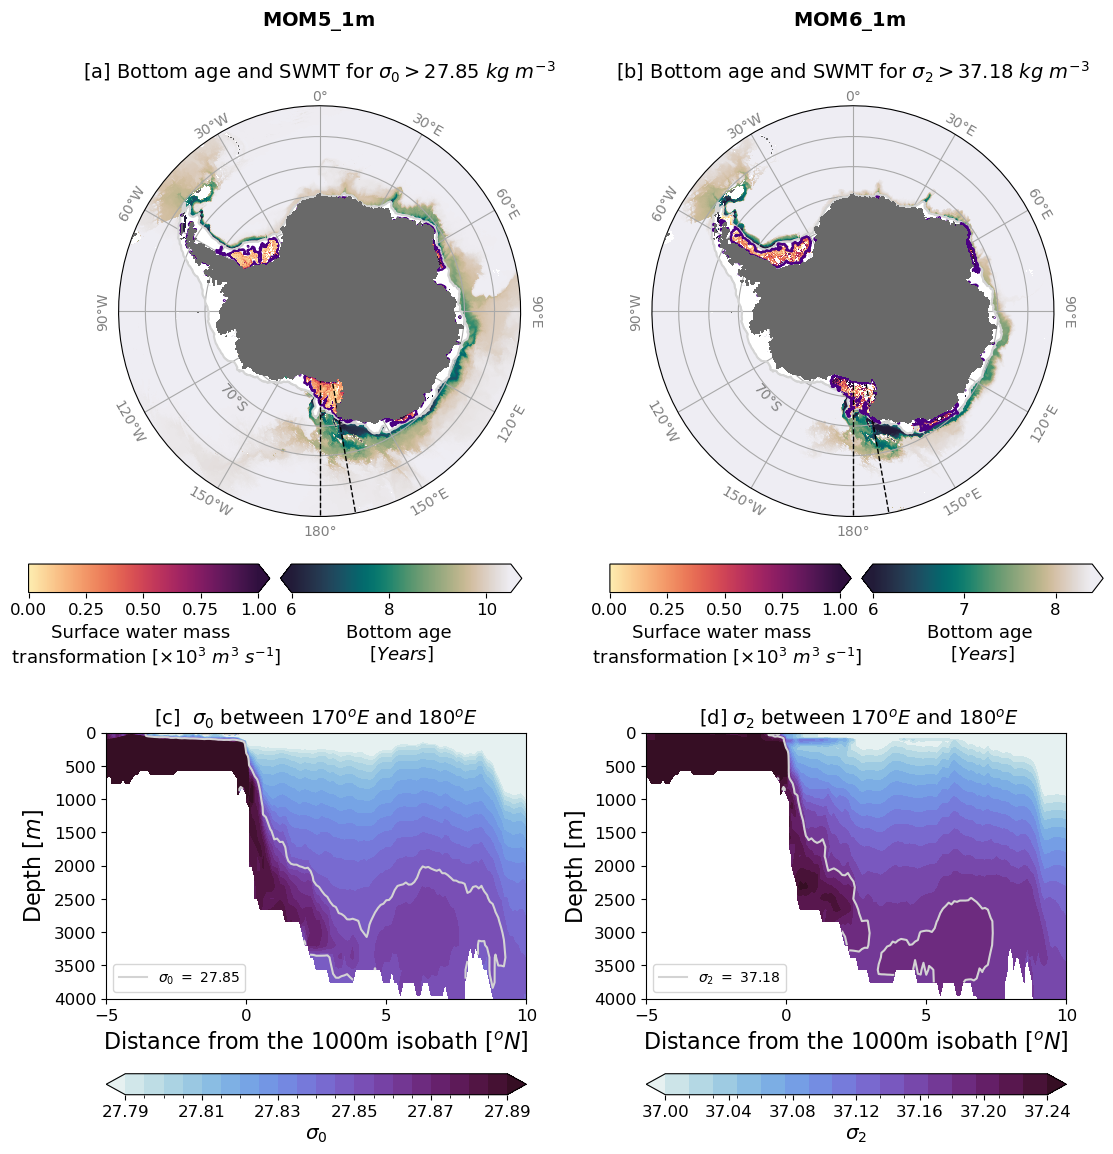

In [61]:
figure = plt.figure(num = 1, figsize = (12, 19))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.25,
                    hspace=0.35)

SWMT_contour_color = 'indigo'
SWMT_contour_thickness = 1.6

#DSW definition polygon for MOM5
MOM5_σ0_poly = Polygon([(-3,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-3,σ0_DSW_1m_maxdens),(-3,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

#DSW definition polygon for MOM6
MOM6_σ2_poly = Polygon([(-3,σ2_DSW_1m_mindens), (10,σ2_DSW_1m_mindens),(10,σ2_DSW_1m_maxdens), (-3,σ2_DSW_1m_maxdens),(-3,σ2_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

yearind=slice(8,10)
#plots a and b, zonal means of density
#ax_bl = plt.subplot(3,2,5)
ax_bl = figure.add_axes([0.1, 0.37, 0.35, 0.2]) 
#levels_MOM5=[σ0_ref]
levels_MOM5=[σ0_DSW_1m_mindens]
levels_MOM5_n=np.arange(27.79,27.89,.005) #np.arange(27.8,27.86,.005)
σ0_ref = np.round(σ0_DSW_1m_mindens,2)
cf = (σ0_OM2_1m_ZM_lat_aligned_ross-1000).plot.contourf(levels=levels_MOM5_n,\
                                       add_colorbar=False,cmap=cmo.dense,ax = ax_bl); 
plt.xticks([-5, 0, 5, 10],fontsize=12); 

plt.yticks(fontsize=12);
cb = plt.colorbar(cf,ticks=[27.79, 27.81, 27.83, 27.85, 27.87, 27.89]\
                 , orientation='horizontal',anchor =  (0.5,0.5));
cb.set_label(label=r'$\sigma_0$',size='x-large', weight='bold')
cb.ax.tick_params(labelsize='large')
cl = (σ0_OM2_1m_ZM_lat_aligned_ross -1000).plot.contour(levels=levels_MOM5,colors='lightgray',ax = ax_bl);
plt.plot([-20,-20],[0,0],color='lightgray',label=r'$\sigma_0 \ = \ $' + str(np.round(levels_MOM5[0]*100)/100));
plt.ylabel(r'Depth [$m$]',fontsize=16);
plt.xlabel(r'Distance from the 1000m isobath [$^oN$]', fontsize=16)
#plt.clabel(cl); 
plt.ylim(4000,0);plt.xlim(-5,10)
plt.title(r'[c]  $\sigma_0$' + r' between $170^oE$ and $180^oE$', fontsize=14)
plt.legend(loc=3)

ax_br = figure.add_axes([0.55, 0.37, 0.35, 0.2]) 
levels_MOM6=[σ2_DSW_1m_mindens]
σ2_ref = σ2_DSW_1m_mindens
levels_MOM6_n=np.arange(37.0,37.24,.015) #np.arange(37.0,37.2,.015)
cf2 = (σ0_MOM6_1m_ZM_lat_aligned_ross-1000).plot.contourf(levels=levels_MOM6_n,\
                                       add_colorbar=False,cmap=cmo.dense,ax = ax_br); 
plt.xticks([-5, 0, 5, 10],fontsize=12); 
plt.yticks(fontsize=12);
cb2 = plt.colorbar(cf2,ticks=[37.0, 37.04, 37.08, 37.12,  37.16,  37.20, 37.24],\
                   orientation='horizontal',anchor =  (0.5,0.5)); cb2.set_label(label=r'$\sigma_2$',size='x-large', weight='bold')
cb2.ax.tick_params(labelsize='large')
plt.plot([-20,-20],[0,0],color='lightgray',label=r'$\sigma_2 \ = \ $' + str(np.round(levels_MOM6[0]*100)/100));
clMOM6 = (σ0_MOM6_1m_ZM_lat_aligned_ross-1000).plot.contour(levels=levels_MOM6,colors='lightgray',ax = ax_br); 
plt.ylabel('Depth [m]',fontsize=16);
plt.xlabel(r'Distance from the 1000m isobath [$^oN$]',fontsize=16)
#plt.clabel(clMOM6); 
plt.ylim(4000,0);plt.xlim(-5,10)
plt.title(r' [d] $\sigma_2$' + r' between $170^oE$ and $180^oE$', fontsize=14)
plt.legend(loc=3)


# # SWMT + mass transport in the same density level
# ax_c = plt.subplot(3,2,5)
# plt.plot(Overflowsum_OM1mtop.isel(year=yearind).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
#          Overflowsum_OM1mtop.isopycnal_bins,linestyle='-.', label='Overflow')
# plt.plot(swmt21mbath_sum.isel(time=yearind).mean('time'), isopycnal_bin_midmom5_ctrl[0,:],\
#          color='tab:blue', label='SWMT')
# # plt.plot(swmt21mbath_sum_DSW.isel(time=yearind).mean('time'), isopycnal_bin_midmom5_ctrl[0,:],\
# #          color='royalblue', linewidth = 4, linestyle= '--', label='DSW formation')
# plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
# ax_c.add_patch(MOM5_σ0_poly)
# plt.xticks(fontsize=12); plt.yticks(fontsize=12);
# plt.xlim(-1,9)
# #plt.scatter(3.6, σ0_ref, color='tab:blue',label=r'$\sigma_0 =$'+str(σ0_ref)); 
# plt.ylim((28.2,27.4))
# plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
# plt.xlabel(r'$Sv$', fontsize=16)
# plt.legend(fontsize=12)
# plt.title(r"[e] Volume flux per $\sigma_0$ layer",fontsize=14)


# ax_d = plt.subplot(3,2,6)
# plt.plot(ShelfWMT_1dz.isel(time=yearind).mean('time')/1e6, \
#          ShelfWMT_1dz.isopycnal_bins, color='tab:blue', label='SWMT')
# plt.plot(Overflowsum_P1mtop.isel(year=yearind).mean('year').vol_trans_across_contour.cumsum('rho2_l'),\
#          Overflowsum_P1mtop.rho2_l-1000,linestyle='-.', label='Overflow')
# plt.xticks(fontsize=12); plt.yticks(fontsize=12);
# # plt.plot(ShelfWMT_1dz_DSW.isel(time=yearind).mean('time')/1e6, \
# #          ShelfWMT_1dz_DSW.isopycnal_bins,color='royalblue',\
# #          linewidth = 4, linestyle= '--', label='DSW formation')
# ax_d.add_patch(MOM6_σ2_poly)
# plt.ylim((37.55,36.8));plt.xlim(-1,9)
# plt.legend(fontsize=12)
# plt.ylabel(r'$\sigma_2$ (kg m$^{-3}$)', fontsize = 16)
# plt.xlabel(r'$Sv$', fontsize=16)
# plt.title(r"[f] Volume flux per $\sigma_2$ layer",fontsize=14)
# plt.plot([0, 0], [36,37.5], 'k', linewidth=0.5)


#maps with SWMT + ageOB ( Gee!)
proj = ccrs.PlateCarree()
ax325 = plt.subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax325.set_extent([-180, 180, -90, -55], proj)
ax325.set_boundary(circle, transform=ax325.transAxes)

gl = ax325.gridlines(draw_labels=False, color='darkgray')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
             '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
                 -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax325.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax325.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=proj)


plt.plot([-180,-180],[-90,-50],
             color = 'black', linestyle = '--', linewidth=1,
            transform=proj, zorder=4)
plt.plot([-190,-190],[-90,-50],
             color = 'black', linestyle = '--', linewidth=1,
            transform=proj, zorder=4)

ax325.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=6)



plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'lightgray', linewidth=.7,
            transform=proj,)


p325_contour = ax325.contour(swmt21mbath_shelf_spatialplot.xt_ocean, swmt21mbath_shelf_spatialplot.yt_ocean,
                   swmt21mbath_shelf_spatialplot.sel(isopycnal_bins=slice(σ0_ref-.05,2000)).sum('isopycnal_bins')\
                             /1e3,\
                        levels=1,
                   colors=SWMT_contour_color, transform=proj,linewidths=SWMT_contour_thickness,
                   rasterized=True, zorder=2)

p325 = ax325.pcolormesh(swmt21mbath_shelf_spatialplot.xt_ocean, swmt21mbath_shelf_spatialplot.yt_ocean,
                   swmt21mbath_shelf_spatialplot.sel(isopycnal_bins=σ0_ref,method='nearest')/1e3,\
                        vmin=0, vmax=1,
                   cmap=cmo.matter, transform=proj,
                   rasterized=True, zorder=3)







pos = ax325.get_position()
cax = plt.axes([pos.xmin-.075, pos.ymin-0.04,
                .6*(pos.xmax-pos.xmin), 0.015])


cb325 = plt.colorbar(p325, orientation='horizontal', cax=cax, extend='max')
cb325.ax.tick_params(labelsize=12)
cb325.ax.set_xlabel('Surface water mass \n transformation ' +
                 r'[$\times 10^{3}\ m^{3}\ s^{-1}$]',fontsize=13)


p325_1 = ax325.pcolormesh(ageob_OM2_1m_offshelf.xt_ocean, ageob_OM2_1m_offshelf.yt_ocean,
                   ageob_OM2_1m_offshelf,\
                        vmin=6, vmax=10.5,
                   cmap=cmo.rain_r, transform=proj,
                   rasterized=True, zorder=0)

cax_0T = plt.axes([pos.xmin+0.135, pos.ymin-0.04,
                .6*(pos.xmax-pos.xmin), 0.015])
cb325_1 = plt.colorbar(p325_1, orientation='horizontal', cax=cax_0T, extend='both')
cb325_1.ax.tick_params(labelsize=12)
cb325_1.ax.set_xlabel('Bottom age \n' +
                 r'[$Years$]',fontsize=13)
ax325.set_title(r'$\bf{MOM5}$_$\bf{1m}$' \
          +' \n \n'+'[a] Bottom age and SWMT for ' +  r'$\sigma_0>$' + str(σ0_ref) + ' $kg\ m^{-3}$', pad=20, fontsize=14)









## subplot MOM6
ax326 = plt.subplot(3,2,2, projection=ccrs.SouthPolarStereo())

ax326.set_extent([-180, 180, -90, -55], proj)
ax326.set_boundary(circle, transform=ax326.transAxes)

gl2 = ax326.gridlines(draw_labels=False, color='darkgray')
gl2.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))

for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax326.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax326.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=proj)

plt.plot([-180,-180],[-90,-50],
             color = 'black', linestyle = '--', linewidth=1,
            transform=proj,zorder=4)
plt.plot([-190,-190],[-90,-50],
             color = 'black', linestyle = '--', linewidth=1,
            transform=proj,zorder=4)


ax326.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=6)

plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'lightgray', linewidth=.7,
            transform=proj)

p326_contour = ax326.contour(ShelfWMT_1dz_spatialplot.xh, ShelfWMT_1dz_spatialplot.yh+0.2,
                   (shelf_mask_MOM6_nan * \
                    ShelfWMT_1dz_spatialplot.sel(isopycnal_bins=slice(σ2_ref+.012,2000)).sum('isopycnal_bins'))\
                             /1e3,\
                        levels=[0,],
                   colors=SWMT_contour_color, transform=proj,linewidths=SWMT_contour_thickness,
                   rasterized=True, zorder=4)


p326 = ax326.pcolormesh(ShelfWMT_1dz_spatialplot.xh, ShelfWMT_1dz_spatialplot.yh,
                   (shelf_mask_MOM6_nan * \
                    ShelfWMT_1dz_spatialplot.sel(isopycnal_bins=σ2_ref,method='nearest'))/1e3,\
                        vmin=0, vmax=1,
                   cmap=cmo.matter, transform=proj,
                   rasterized=True, zorder=3)
pos_2 = ax326.get_position()
cax_2 = plt.axes([pos_2.xmin-.035, pos_2.ymin-0.04,
                .6*(pos_2.xmax-pos_2.xmin), 0.015])
cb326 = plt.colorbar(p326, orientation='horizontal', cax=cax_2, extend='max')
cb326.ax.tick_params(labelsize=12)
cb326.ax.set_xlabel('Surface water mass \n transformation ' +
                 r'[$\times 10^{3}\ m^{3}\ s^{-1}$]',fontsize=13)

p326_1 = ax326.pcolormesh(ageob_MOM6_1m_offshelf.xh, ageob_MOM6_1m_offshelf .yh,
                   ageob_MOM6_1m_offshelf ,\
                        vmin=6, vmax=8.4,
                   cmap=cmo.rain_r, transform=proj,
                   rasterized=True, zorder=0)

cax_0T2 = plt.axes([pos_2.xmin+0.175, pos_2.ymin-0.04,
                .6*(pos_2.xmax-pos_2.xmin), 0.015])
cb326_1 = plt.colorbar(p326_1, orientation='horizontal', cax=cax_0T2, extend='both')
cb326_1.ax.tick_params(labelsize=12)
cb326_1.ax.set_xlabel('Bottom age \n' +
                 r'[$Years$]',fontsize=13)

ax326.set_title(r'$\bf{MOM6}$_$\bf{1m}$' +'  \n \n'+'[b] Bottom age and SWMT for ' +  r'$\sigma_2>$' + str(σ2_ref) + ' $kg\ m^{-3}$', pad=20, fontsize=14)


In [62]:
#Logical test with KDS75 + 0.25 deg

lastdata_025_kds = xr.open_dataset('/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_ryf8485_KDS75/output115/ocean/ocean.nc')
lastdata_025_GFDL = xr.open_dataset('/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_ryf8485_spinup_A/output008/ocean/ocean.nc')


# KDS75
age_025_KDS  = lastdata_025_kds.age_global.isel(time=0).sel(yt_ocean=slice(-90,-40))

depth_array_025 = age_025_KDS * 0 + age_025_KDS.st_ocean
max_depth_025 = depth_array_025.max(dim = 'st_ocean', skipna= True)
ageob_025_KDS = age_025_KDS.where(depth_array_025.st_ocean >= max_depth_025)
ageob_025_KDS = ageob_025_KDS.sum(dim = 'st_ocean')

# GFDL50
age_025_GFDL  = lastdata_025_GFDL.age_global.isel(time=0).sel(yt_ocean=slice(-90,-40))

depth_array_GFDL = (age_025_GFDL * 0) + age_025_GFDL.st_ocean
max_depth_GFDL = depth_array_GFDL.max(dim = 'st_ocean', skipna= True)
ageob_025_GFDL = age_025_GFDL.where(depth_array_GFDL.st_ocean >= max_depth_GFDL)
ageob_025_GFDL = ageob_025_GFDL.sum(dim = 'st_ocean')




In [63]:
# figure = plt.figure(num = 1, figsize = (12, 19))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.25,
#                     hspace=0.35)

# #maps with SWMT + ageOB ( Gee!)
# proj = ccrs.PlateCarree()
# ax325 = plt.subplot(3,2,1, projection=ccrs.SouthPolarStereo())
# ax325.set_extent([-180, 180, -90, -55], proj)
# ax325.set_boundary(circle, transform=ax325.transAxes)

# gl = ax325.gridlines(draw_labels=False, color='darkgray')
# gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
# label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
#              '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
# rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
# lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
#                  -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
# for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
#                               30, -150, 150, -30]):
#     ax325.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
#             horizontalalignment='center', verticalalignment='center',
#             color='gray', fontsize=10, transform=proj)
# for j in range(70, 90, 10):
#     label = str(j) + '°S'
#     ax325.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
#             verticalalignment='center', color='gray', fontsize=10,
#             transform=proj)


# plt.plot([-180,-180],[-90,-50],
#              color = 'black', linestyle = '--', linewidth=1,
#             transform=proj, zorder=4)
# plt.plot([-190,-190],[-90,-50],
#              color = 'black', linestyle = '--', linewidth=1,
#             transform=proj, zorder=4)

# ax325.contourf(land_mask.xt_ocean.values,
#             np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
#             land_mask, colors='dimgray', levels=[0.5, 2],
#             transform=proj, rasterized=True, zorder=6)



# plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
#             levels=[0, 1], colors = 'lightgray', linewidth=.7,
#             transform=proj,)





# p325_1 = ax325.pcolormesh(ageob_025_KDS.xt_ocean, ageob_025_KDS.yt_ocean,
#                    ageob_025_KDS.where(max_depth_025>1000),\
#                         vmin=6, vmax=20.5,
#                    cmap=cmo.rain_r, transform=proj,
#                    rasterized=True, zorder=0)


# cax_0T = plt.axes([pos.xmin+0.05, pos.ymin-0.04,
#                 .6*(pos.xmax-pos.xmin), 0.015])
# cb325_1 = plt.colorbar(p325_1, orientation='horizontal', cax=cax_0T, extend='both')
# cb325_1.ax.tick_params(labelsize=12)
# cb325_1.ax.set_xlabel('Bottom age \n' +
#                  r'[$Years$]',fontsize=13)
# ax325.set_title(r'$\bf{MOM5}$_$\bf{0.25^0}$_$\bf{KDS75}$' \
#           +' \n \n'+'[a] Bottom age for z > 1000m, year 199', pad=20, fontsize=14)



In [64]:
# figure = plt.figure(num = 1, figsize = (12, 19))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.25,
#                     hspace=0.35)


# #maps with SWMT + ageOB ( Gee!)
# proj = ccrs.PlateCarree()
# ax325 = plt.subplot(3,2,1, projection=ccrs.SouthPolarStereo())
# ax325.set_extent([-180, 180, -90, -55], proj)
# ax325.set_boundary(circle, transform=ax325.transAxes)

# gl = ax325.gridlines(draw_labels=False, color='darkgray')
# gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
# label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
#              '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
# rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
# lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
#                  -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
# for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
#                               30, -150, 150, -30]):
#     ax325.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
#             horizontalalignment='center', verticalalignment='center',
#             color='gray', fontsize=10, transform=proj)
# for j in range(70, 90, 10):
#     label = str(j) + '°S'
#     ax325.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
#             verticalalignment='center', color='gray', fontsize=10,
#             transform=proj)


# plt.plot([-180,-180],[-90,-50],
#              color = 'black', linestyle = '--', linewidth=1,
#             transform=proj, zorder=4)
# plt.plot([-190,-190],[-90,-50],
#              color = 'black', linestyle = '--', linewidth=1,
#             transform=proj, zorder=4)

# ax325.contourf(land_mask.xt_ocean.values,
#             np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
#             land_mask, colors='dimgray', levels=[0.5, 2],
#             transform=proj, rasterized=True, zorder=6)



# plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
#             levels=[0, 1], colors = 'lightgray', linewidth=.7,
#             transform=proj,)





# p325_1 = ax325.pcolormesh(ageob_025_KDS.xt_ocean, ageob_025_KDS.yt_ocean,
#                    ageob_025_KDS.where(max_depth_025>1000),\
#                         vmin=6, vmax=10.2,
#                    cmap=cmo.rain_r, transform=proj,
#                    rasterized=True, zorder=0)


# cax_0T = plt.axes([pos.xmin+0.05, pos.ymin-0.04,
#                 .6*(pos.xmax-pos.xmin), 0.015])
# cb325_1 = plt.colorbar(p325_1, orientation='horizontal', cax=cax_0T, extend='both')
# cb325_1.ax.tick_params(labelsize=12)
# cb325_1.ax.set_xlabel('Bottom age \n' +
#                  r'[$Years$]',fontsize=13)
# ax325.set_title(r'$\bf{MOM5}$_$\bf{0.25^0}$_$\bf{KDS75}$' \
#           +' \n \n'+'[a] Bottom age for z > 1000m, year 11', pad=20, fontsize=14)








# #maps with SWMT + ageOB ( Gee!)
# proj = ccrs.PlateCarree()
# ax326 = plt.subplot(3,2,2, projection=ccrs.SouthPolarStereo())
# ax326.set_extent([-180, 180, -90, -55], proj)
# ax326.set_boundary(circle, transform=ax326.transAxes)

# gl = ax326.gridlines(draw_labels=False, color='darkgray')
# gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
# label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
#              '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
# rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
# lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
#                  -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
# for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
#                               30, -150, 150, -30]):
#     ax326.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
#             horizontalalignment='center', verticalalignment='center',
#             color='gray', fontsize=10, transform=proj)
# for j in range(70, 90, 10):
#     label = str(j) + '°S'
#     ax326.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
#             verticalalignment='center', color='gray', fontsize=10,
#             transform=proj)


# plt.plot([-180,-180],[-90,-50],
#              color = 'black', linestyle = '--', linewidth=1,
#             transform=proj, zorder=4)
# plt.plot([-190,-190],[-90,-50],
#              color = 'black', linestyle = '--', linewidth=1,
#             transform=proj, zorder=4)

# ax326.contourf(land_mask.xt_ocean.values,
#             np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
#             land_mask, colors='dimgray', levels=[0.5, 2],
#             transform=proj, rasterized=True, zorder=6)



# plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
#             levels=[0, 1], colors = 'lightgray', linewidth=.7,
#             transform=proj,)


# p326_1 = ax326.pcolormesh(ageob_025_GFDL.xt_ocean, ageob_025_GFDL.yt_ocean,
#                    ageob_025_GFDL.where(max_depth_GFDL>1000),\
#                         vmin=6, vmax=10.2,
#                    cmap=cmo.rain_r, transform=proj,
#                    rasterized=True, zorder=0)


# cax_0T = plt.axes([pos.xmin+0.05, pos.ymin-0.04,
#                 .6*(pos.xmax-pos.xmin), 0.015])
# cb326_1 = plt.colorbar(p326_1, orientation='horizontal', cax=cax_0T, extend='both')
# cb326_1.ax.tick_params(labelsize=12)
# cb326_1.ax.set_xlabel('Bottom age \n' +
#                  r'[$Years$]',fontsize=13)
# ax326.set_title(r'$\bf{MOM5}$_$\bf{0.25^0}$_$\bf{GFDL}$' \
#           +' \n \n'+'[a] Bottom age for z > 1000m, year 11', pad=20, fontsize=14)



In [65]:
#and for OM2, 1m case ##################################
#σ0_DSW_1m_mindens.values, σ0_DSW_1m_maxdens.values

swmt21mbath_sum_DSW =  swmt21mbath_sum.where(swmt21mbath_sum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmt21mbath_sum.isopycnal_bins<=σ0_DSW_1m_maxdens)



# #and for OM2, 0.5m case ##################################
swmthalfMtop_sum_DSW =  swmthalfMtop_sum.where(swmthalfMtop_sum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmthalfMtop_sum.isopycnal_bins<=σ0_DSW_1m_maxdens)




# #and for OM2, 5m case ##################################
swmt5mtop_sum_DSW =  swmt5mtop_sum.where(swmt5mtop_sum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmt5mtop_sum.isopycnal_bins<=σ0_DSW_1m_maxdens)

In [66]:
swmt21mbath_sum

<xarray.DataArray (time: 10, isopycnal_bins: 249)> Size: 20kB
array([[-0.1364009 , -0.25374261, -0.11686145, ...,  0.00882551,
         0.00068531,  0.00738951],
       [-0.20618138, -0.12302309, -0.1389106 , ...,  0.00570914,
         0.00751775,  0.00755562],
       [-0.2303395 , -0.17090605, -0.19010871, ...,  0.00354801,
         0.006072  ,  0.00623439],
       ...,
       [-0.24331019, -0.20245552, -0.20470474, ...,  0.0063805 ,
         0.00594725,  0.00076794],
       [-0.31610046, -0.20143197, -0.23078105, ...,  0.00196743,
         0.00255806,  0.00437299],
       [-0.29305394, -0.27813324, -0.15505654, ...,  0.00512208,
         0.00359445,  0.00484551]])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 2kB 24.01 24.03 ... 28.95 28.97
  * time            (time) int64 80B 1991 1992 1993 1994 ... 1997 1998 1999 2000

In [67]:
#CUMSUM

swmt21mbath_cumsum_DSW =  swmt21mbath_cumsum.where(swmt21mbath_cumsum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmt21mbath_cumsum.isopycnal_bins<=σ0_DSW_1m_maxdens)



# #and for OM2, 0.5m case ##################################
swmthalfMtop_cumsum_DSW =  swmthalfMtop_cumsum.where(swmthalfMtop_cumsum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmthalfMtop_cumsum.isopycnal_bins<=σ0_DSW_1m_maxdens)




# #and for OM2, 5m case ##################################
swmt5mtop_cumsum_DSW =  swmt5mtop_cumsum.where(swmt5mtop_cumsum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmt5mtop_cumsum.isopycnal_bins<=σ0_DSW_1m_maxdens)

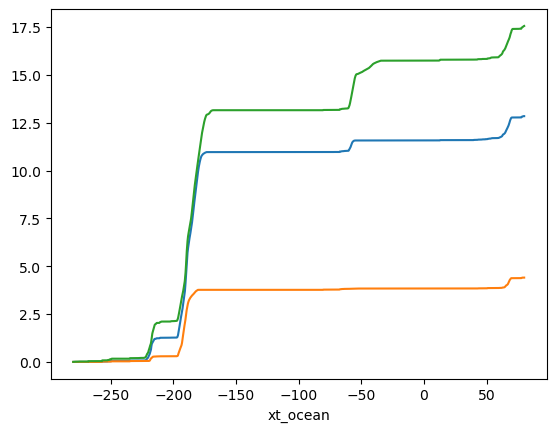

In [68]:
swmt21mbath_cumsum_DSW.isel(time=slice(8,10)).mean('time').sum('isopycnal_bins').plot()
swmt5mtop_cumsum_DSW.isel(time=slice(8,10)).mean('time').sum('isopycnal_bins').plot()
swmthalfMtop_cumsum_DSW.isel(time=slice(8,10)).mean('time').sum('isopycnal_bins').plot()


In [69]:
#YSUM
lon_10deg_bins=np.arange(-280,80,10)
swmt21mbath_ysum_DSW =  swmt21mbath_ysum.where(swmt21mbath_ysum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmt21mbath_ysum.isopycnal_bins<=σ0_DSW_1m_maxdens).groupby_bins('xt_ocean',bins = lon_10deg_bins).sum()



# #and for OM2, 0.5m case ##################################
swmthalfMtop_ysum_DSW =  swmthalfMtop_ysum.where(swmthalfMtop_ysum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmthalfMtop_ysum.isopycnal_bins<=σ0_DSW_1m_maxdens).groupby_bins('xt_ocean',bins = lon_10deg_bins).sum()




# #and for OM2, 5m case ##################################
swmt5mtop_ysum_DSW =  swmt5mtop_ysum.where(swmt5mtop_ysum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmt5mtop_ysum.isopycnal_bins<=σ0_DSW_1m_maxdens).groupby_bins('xt_ocean',bins = lon_10deg_bins).sum()


Interestingly, all regions seem to decrease DSW formation as we decrease vertical resolution

In [70]:
## for MOM6  1m case ####################
ShelfWMT_1dz_DSW  =ShelfWMT_1dz.where(ShelfWMT_1dz.isopycnal_bins>=σ2_DSW_1m_mindens).\
where(ShelfWMT_1dz.isopycnal_bins<=σ2_DSW_1m_maxdens)


## for MOM6  5m case ####################
ShelfWMT_5dz_DSW  =ShelfWMT_5dz.where(ShelfWMT_5dz.isopycnal_bins>=σ2_DSW_1m_mindens).\
where(ShelfWMT_5dz.isopycnal_bins<=σ2_DSW_1m_maxdens)

In [71]:
#CUMSUM
## for MOM6  1m case ####################
ShelfWMT_1dz_DSW =ShelfWMT_1dz_cumsum.where(ShelfWMT_1dz_cumsum.isopycnal_bins>=σ2_DSW_1m_mindens).\
where(ShelfWMT_1dz_cumsum.isopycnal_bins<=σ2_DSW_1m_maxdens)


## for MOM6  5m case ####################
ShelfWMT_5dz_DSW_cumsum =ShelfWMT_5dz_cumsum.where(ShelfWMT_5dz_cumsum.isopycnal_bins>=σ2_DSW_1m_mindens).\
where(ShelfWMT_5dz_cumsum.isopycnal_bins<=σ2_DSW_1m_maxdens)

In [72]:
ShelfWMT_1dz.load()
ShelfWMT_5dz.load()

<xarray.DataArray (time: 10, isopycnal_bins: 160)> Size: 13kB
array([[2.20806195e+06, 2.36186755e+06, 2.38071922e+06, ...,
        7.28581473e+03, 1.09304657e+04, 7.72585880e+03],
       [2.26404308e+06, 2.50493490e+06, 2.67539015e+06, ...,
        3.13547633e+03, 1.32579150e+04, 0.00000000e+00],
       [2.76086912e+06, 2.72753616e+06, 2.82528349e+06, ...,
        0.00000000e+00, 1.93355280e+04, 1.53655596e+04],
       ...,
       [3.03985019e+06, 3.08639622e+06, 3.15498270e+06, ...,
        4.18356835e+03, 4.45101157e+03, 6.68256583e+03],
       [2.87672055e+06, 2.91705690e+06, 2.98750816e+06, ...,
        0.00000000e+00, 1.02267013e+04, 0.00000000e+00],
       [3.03089945e+06, 3.18400722e+06, 2.86198025e+06, ...,
        6.79859644e+03, 6.65558326e+03, 0.00000000e+00]])
Coordinates:
  * time            (time) int64 80B 1991 1992 1993 1994 ... 1997 1998 1999 2000
  * isopycnal_bins  (isopycnal_bins) float64 1kB 36.8 36.81 36.81 ... 37.59 37.6

In [73]:
import matplotlib.image as mpimg

In [74]:
ShelfWMT_5dz_weakwinds.load()
print('data loaded')

data loaded


this shows that weakening the winds to the level of the 1m simulation dont fix the problem (SWMT still the same). so the total transport perhaps do not matter.

Next: try a 1 meter simulation with stronger winds.... i.e., if this simulation has the same SWMT as 1m then that means that what matter is solving the spiral, not the total transport.

In [75]:
DSW_overflow_cumsum_1mtop = (Overflowsum_OM1mtop_cumsum.cumsum('isopycnal_bins').where(Overflowsum_OM1mtop_cumsum.isopycnal_bins>σ0_DSW_1m_mindens)\
.isel(year=slice(8,10)).mean('year').max('isopycnal_bins')/1e6).vol_trans_across_contour_binned

DSW_overflow_cumsum_5mtop = (Overflowsum_OM5mtop_cumsum.cumsum('isopycnal_bins').where(Overflowsum_OM5mtop_cumsum.isopycnal_bins>σ0_DSW_1m_mindens)\
.isel(year=slice(8,10)).mean('year').max('isopycnal_bins')/1e6).vol_trans_across_contour_binned

#OMhalfMtop
DSW_overflow_cumsum_halfMtop = (Overflowsum_OMhalfMtop_cumsum.cumsum('isopycnal_bins').where(Overflowsum_OMhalfMtop_cumsum.isopycnal_bins>σ0_DSW_1m_mindens)\
.isel(year=slice(8,10)).mean('year').max('isopycnal_bins')/1e6).vol_trans_across_contour_binned

In [76]:
u_along_unbinned_fine = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_rho/OM2_IAF_XYgrid/Antarctic_slope_contour_1km_velocities_2018-12-01_uv.nc')
lon_along_contour = u_along_unbinned_fine.lon_along_contour.compute()
lat_along_contour = u_along_unbinned_fine.lat_along_contour.compute()

In [77]:
# The sum of overflow will be
Overflowsum_OM5mtop_nosum = OM2_5mtop_voltrans.isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_OM1mtop_nosum = OM2_21mbath_voltrans.isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_OMhalfMtop_nosum = OM2_halfMtop_voltrans.isel(isopycnal_bins=slice(None, None, -1))

In [78]:
# label_lon = ['80°E','150°E','90°W','0°','40°E', '80°E']

# real_lon = [-280,-210,-90,0,40,80]



In [79]:
# #deciding regional slices base don contour index
# plt.subplot(2,1,1)
# Overflowsum_OM1mtop_nosum.isel(year=9).vol_trans_across_contour_binned.where(Overflowsum_OM1mtop_nosum.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins').cumsum('contour_index').plot()
# Overflowsum_OM5mtop_nosum.isel(year=9).vol_trans_across_contour_binned.where(Overflowsum_OM5mtop_nosum.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins').cumsum('contour_index').plot()
# Overflowsum_OMhalfMtop_nosum.isel(year=9).vol_trans_across_contour_binned.where(Overflowsum_OMhalfMtop_nosum.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins').cumsum('contour_index').plot()
# plt.plot([600,600],[0,2e6],color='black',linestyle = '--')
# plt.plot([1400,1400],[0,2e6],color='black',linestyle = '--')
# plt.plot([2400,2400],[0,2e6],color='black',linestyle = '--')
# plt.plot([3200,3200],[0,2e6],color='black',linestyle = '--')
# plt.plot([4700,4700],[0,2e6],color='black',linestyle = '--')
# plt.plot([5550,5550],[0,2e6],color='black',linestyle = '--')
# plt.xlim(0,6002)
# #plt.ylim(-1e5,2.5e6)

# plt.subplot(2,1,2)
# plt.plot(lon_along_contour,lat_along_contour)
# #plt.xticks(ticks = real_lon,labels = label_lon,fontsize=12)
# plt.xticks(ticks = np.sort(np.append(real_lon,-230)))
# plt.xlim(-280,80)
# plt.grid()
# #slices in contour index will be:
# Adelie_slice  = slice(600,1400)
# Adelie_slice_lon  = slice(-280,-210)
# Ross_slice  = slice(1201,2400)
# Ross_slice_lon  = slice(-210,-65)
# Weddell_slice  = slice(3200,4700)
# Weddell_slice_lon  = slice(-65,40)
# Prydz_slice  = slice(5550,6002)
# Prydz_slice_lon  = slice(40,80)
# #bin grouping = 
# contour_groups = [0,1200,3600,5550,6002]

In [80]:
label_lon = ['80°E','100°E','160°E','140°W','65°W','10°W','30°E','80°E']

real_lon = [-280,-250,-200,-140,-65,-10,30,80]


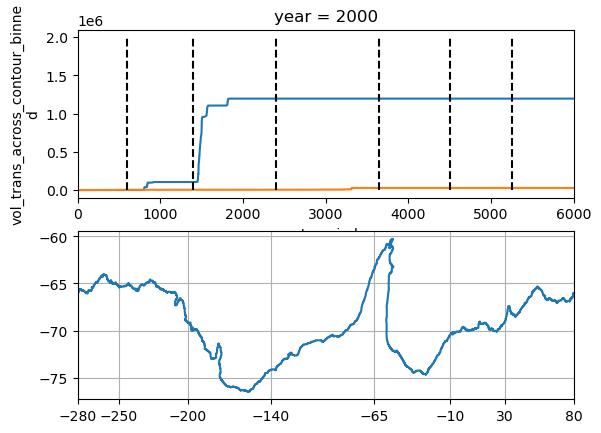

In [81]:
#deciding regional slices base don contour index
plt.subplot(2,1,1)
Overflowsum_OM1mtop_nosum.isel(year=9).vol_trans_across_contour_binned.where(Overflowsum_OM1mtop_nosum.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins').cumsum('contour_index').plot()
Overflowsum_OM5mtop_nosum.isel(year=9).vol_trans_across_contour_binned.where(Overflowsum_OM5mtop_nosum.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins').cumsum('contour_index').plot()
#Overflowsum_OMhalfMtop_nosum.isel(year=9).vol_trans_across_contour_binned.where(Overflowsum_OMhalfMtop_nosum.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins').cumsum('contour_index').plot()
plt.plot([600,600],[0,2e6],color='black',linestyle = '--')
plt.plot([1400,1400],[0,2e6],color='black',linestyle = '--')
plt.plot([2400,2400],[0,2e6],color='black',linestyle = '--')
plt.plot([3650,3650],[0,2e6],color='black',linestyle = '--')#3650, 3800
plt.plot([4500,4500],[0,2e6],color='black',linestyle = '--') #4350 4500
plt.plot([5250,5250],[0,2e6],color='black',linestyle = '--')
plt.xlim(0,6002)
#plt.ylim(-1e5,2.5e6)

plt.subplot(2,1,2)
plt.plot(lon_along_contour,lat_along_contour)
#plt.xticks(ticks = real_lon,labels = label_lon,fontsize=12)
plt.xticks(ticks = real_lon)
plt.xlim(-280,80)
plt.grid()
#slices in contour index will be:
Adelie_slice  = slice(600,1400) #np.append(np.arange(0,1400),np.arange(5700,6002))#slice(0,1400) #600
Adelie_slice_lon  = slice(-280,-200)
Ross_slice  = slice(1401,2400)
Ross_slice_lon  = slice(-210,-65)
Weddell_slice  = slice(3650,4500)
Weddell_slice_lon  = slice(-65,-10)
Prydz_slice  = np.append(np.arange(0,430),np.arange(5300,6002))#slice(5250,5850)#np.append(np.arange(0,200),np.arange(5000,6002))#slice(5000,6002)# np.append(np.arange(0,600),np.arange(5000,6002))#
Prydz_slice_lon  = slice(30,80)
#bin grouping = 
contour_groups = [0,1200,3600,5550,6002]

In [82]:
# plt.subplot(2,1,1)

# #adelie
# plt.bar([-240,-150,-40,45],Overflowsum_OM1mtop_nosum.isel(year=slice(8,10)).mean('year').vol_trans_across_contour_binned.where(Overflowsum_OM1mtop_nosum.isopycnal_bins>σ0_DSW_1m_mindens).\
# max('isopycnal_bins').groupby_bins('contour_index',bins = contour_groups).sum()*1e-6,width=10)
# plt.bar(-260,Overflowsum_OM5mtop_nosum.isel(year=slice(8,10)).mean('year').vol_trans_across_contour_binned.where(Overflowsum_OM5mtop_nosum.isopycnal_bins>σ0_DSW_1m_mindens).\
# max('isopycnal_bins').groupby_bins('contour_index',bins = contour_groups).sum()*1e-6,width=10)
# plt.bar(-220,Overflowsum_OMhalfMtop_nosum.isel(year=slice(8,10)).mean('year').vol_trans_across_contour_binned.where(Overflowsum_OMhalfMtop_nosum.isopycnal_bins>σ0_DSW_1m_mindens).\
# max('isopycnal_bins').groupby_bins('contour_index',bins = contour_groups).sum()*1e-6,width=10)




# plt.xticks(ticks = real_lon)
# plt.grid()

# # Overflowsum_OM5mtop_nosum.isel(year=9).vol_trans_across_contour_binned.where(Overflowsum_OM5mtop_nosum.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins').cumsum('contour_index').plot()
# # Overflowsum_OMhalfMtop_nosum.isel(year=9).vol_trans_across_contour_binned.where(Overflowsum_OMhalfMtop_nosum.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins').cumsum('contour_index').plot()
# # plt.plot([1200,1200],[0,2e6],color='black',linestyle = '--')
# # plt.plot([3600,3600],[0,2e6],color='black',linestyle = '--')
# # plt.plot([5350,5350],[0,2e6],color='black',linestyle = '--')
# plt.xlim(-280,80)
# plt.ylim(0,2.5)

# plt.subplot(2,1,2)
# plt.plot(lon_along_contour,lat_along_contour)
# #plt.xticks(ticks = real_lon,labels = label_lon,fontsize=12)
# plt.xticks(ticks = real_lon)
# plt.xlim(-280,80)
# plt.grid()

Interestingly, the outflows on the 1m are all more spatially distributed, and we seem to have waters outflowing all the way from Ross to weddel

(28.2, 27.0)

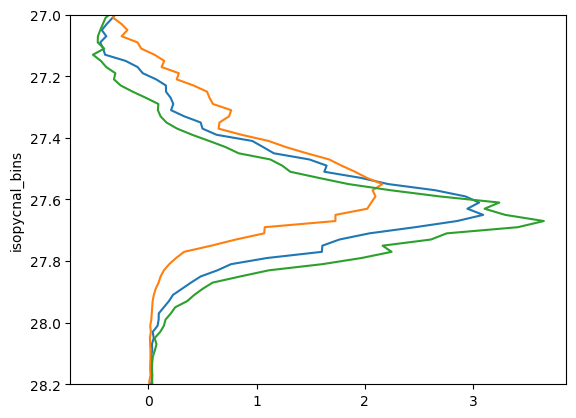

In [85]:
DSWformation_1mtop_perlon = ((swmt21mbath_shelf * areat_shelf/1e6)).sum(('yt_ocean')).isel(time=yearind).mean('time')
DSWformation_5mtop_perlon = ((swmt5mtop_shelf * areat_shelf/1e6)).sum(('yt_ocean')).isel(time=yearind).mean('time')
DSWformation_halfMtop_perlon = ((swmthalfMtop_shelf * areat_shelf/1e6)).sum(('yt_ocean')).isel(time=yearind).mean('time')


DSWformation_1mtop_perlon.sel(xt_ocean=Adelie_slice_lon).sum('xt_ocean').plot(y='isopycnal_bins')
DSWformation_5mtop_perlon.sel(xt_ocean=Adelie_slice_lon).sum('xt_ocean').plot(y='isopycnal_bins')
DSWformation_halfMtop_perlon.sel(xt_ocean=Adelie_slice_lon).sum('xt_ocean').plot(y='isopycnal_bins')
plt.ylim(28.2,27)


Ok, lets plot the 1m and 5m cases

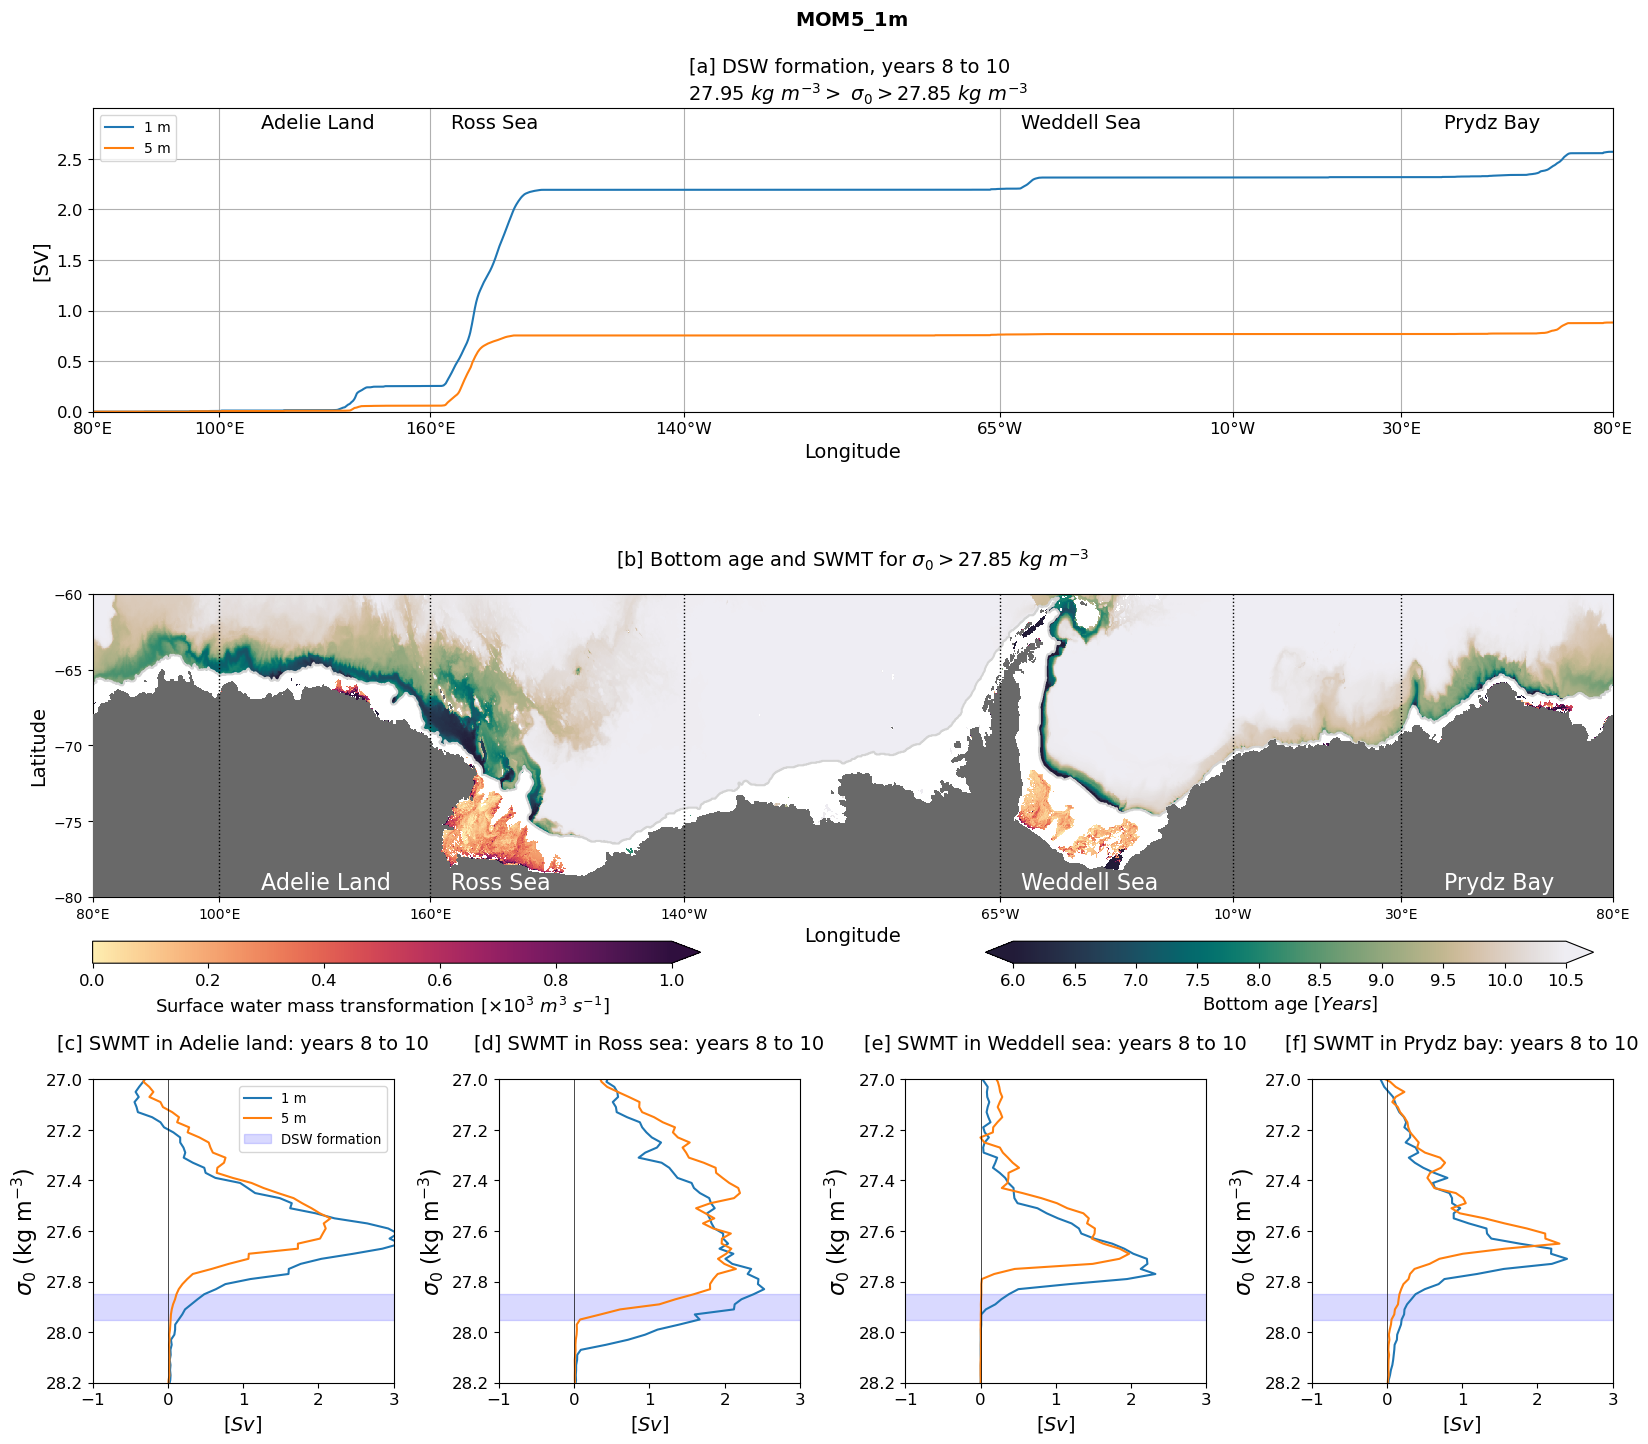

In [92]:
figure = plt.figure(num = 1, figsize = (19, 22))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.35,
                    hspace=0.6)


SWMT_contour_thickness = 1.6

## SWMT PER REGIOS PER MODEL, 10 deg bins


plt.subplot(4,1,1)
#SWMT:
#swmthalfMtop_cumsum_DSW.isel(time=slice(8,10)).mean('time').mean('isopycnal_bins').plot(color='tab:green',label='0.5 m')
swmt21mbath_cumsum_DSW.isel(time=slice(8,10)).mean('time').mean('isopycnal_bins').plot(color='tab:blue',label='1 m')
swmt5mtop_cumsum_DSW.isel(time=slice(8,10)).mean('time').mean('isopycnal_bins').plot(color='tab:orange',label='5 m')
plt.xlim(-280,80); 
plt.legend(fontsize=10); 
plt.yticks(fontsize=12);
plt.grid(); 
plt.text(-240,2.8,'Adelie Land',color='black',fontsize=14,zorder=20)
plt.text(-195,2.8,'Ross Sea',color='black',fontsize=14,zorder=20)
plt.text(-60,2.8,'Weddell Sea',color='black',fontsize=14,zorder=20)
plt.text(40,2.8,'Prydz Bay',color='black',fontsize=14,zorder=20)
#plt.xticks(ticks=[1990,1992,1994,1996,1998,2000], labels=['0','2','4','6','8','10'])
plt.ylabel('[SV]', fontsize=14)
plt.title(r'$\bf{MOM5}$_$\bf{1m}$' \
          +' \n \n'+"[a] DSW formation, years 8 to 10 \n " + r' $27.95\ kg \ m^{-3} >$ $\sigma_0 >$' + str(σ0_ref) + r' $kg \ m^{-3}$',fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.xticks(ticks = real_lon,labels = label_lon,fontsize=12)
plt.yticks(ticks = [0,.5,1,1.5,2,2.5],fontsize=12)
plt.ylim(0,3)










### MAP ##############
ax325 = plt.subplot(4,1,2) # proj = ccrs.PlateCarree()



ax325.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
             rasterized=True, zorder=6)



plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'lightgray', linewidth=.7,
            )



p325 = ax325.pcolormesh(swmt21mbath_shelf_spatialplot.xt_ocean, swmt21mbath_shelf_spatialplot.yt_ocean,
                   swmt21mbath_shelf_spatialplot.sel(isopycnal_bins=σ0_ref,method='nearest')/1e3,\
                        vmin=0, vmax=1,
                   cmap=cmo.matter, 
                   rasterized=True, zorder=3)







pos = ax325.get_position()
cax = plt.axes([pos.xmin, pos.ymin-0.03,
                .4*(pos.xmax-pos.xmin), 0.01])


cb325 = plt.colorbar(p325, orientation='horizontal', cax=cax, extend='max')
cb325.ax.tick_params(labelsize=12)
cb325.ax.set_xlabel('Surface water mass transformation ' +
                 r'[$\times 10^{3}\ m^{3}\ s^{-1}$]',fontsize=13)


p325_1 = ax325.pcolormesh(ageob_OM2_1m_offshelf.xt_ocean, ageob_OM2_1m_offshelf.yt_ocean,
                   ageob_OM2_1m_offshelf,\
                        vmin=6, vmax=10.5,
                   cmap=cmo.rain_r, 
                   rasterized=True, zorder=0)

cax_0T = plt.axes([pos.xmin+0.47, pos.ymin-0.03,
                .4*(pos.xmax-pos.xmin), 0.01])
cb325_1 = plt.colorbar(p325_1, orientation='horizontal', cax=cax_0T, extend='both')
cb325_1.ax.tick_params(labelsize=12)
cb325_1.ax.set_xlabel('Bottom age ' +
                 r'[$Years$]',fontsize=13)
ax325.set_title('[b] Bottom age and SWMT for ' +  r'$\sigma_0>$' + str(σ0_ref) + ' $kg\ m^{-3}$', pad=20, fontsize=14)
ax325.set_ylim([-80, -60])


ax325.plot([-140,-140],[-80,-60],
             color = 'black', linestyle = ':', linewidth=1,
             zorder=10)
ax325.plot([-200,-200],[-80,-60],
             color = 'black', linestyle = ':', linewidth=1,
             zorder=10)
ax325.plot([-65,-65],[-80,-60],
             color = 'black', linestyle = ':', linewidth=1,
             zorder=10)
ax325.plot([-10,-10],[-80,-60],
             color = 'black', linestyle = ':', linewidth=1,
             zorder=10)
ax325.plot([-250,-250],[-80,-60],
             color = 'black', linestyle = ':', linewidth=1,
             zorder=10)
ax325.plot([30,30],[-80,-60],
             color = 'black', linestyle = ':', linewidth=1,
             zorder=10)
ax325.text(-240,-79.5,'Adelie Land',color='white',fontsize=16,zorder=20)
ax325.text(-195,-79.5,'Ross Sea',color='white',fontsize=16,zorder=20)
ax325.text(-60,-79.5,'Weddell Sea',color='white',fontsize=16,zorder=20)
ax325.text(40,-79.5,'Prydz Bay',color='white',fontsize=16,zorder=20)
ax325.set_xticks(ticks = real_lon,labels = label_lon)
ax325.set_yticks(ticks = [-80,-75,-70,-65,-60])
ax325.set_xlabel('Longitude', fontsize=14)
ax325.set_ylabel('Latitude', fontsize=14)


# regional curves of FORMATION #####################################################################################################################################################################

#DSW definition polygon for MOM5
MOM5_σ0_poly = Polygon([(-13,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-13,σ0_DSW_1m_maxdens),(-13,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

ax_441 = plt.subplot(4,4,9)
plt.plot(DSWformation_1mtop_perlon.sel(xt_ocean=Adelie_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:blue',label='1 m')
plt.plot(DSWformation_5mtop_perlon.sel(xt_ocean=Adelie_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_5mtop[0,:], color='tab:orange',label='5 m')


plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
ax_441.add_patch(MOM5_σ0_poly)
#plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
plt.xlim(-1,3); 
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylim((28.2,27));plt.legend(fontsize=9.5)
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel( r'[$Sv$]', fontsize=14)
plt.title('\n \n'+r"[c] SWMT in Adelie land: years 8 to 10" +'\n',fontsize=14)




MOM5_σ0_poly = Polygon([(-13,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-13,σ0_DSW_1m_maxdens),(-13,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

ax_442 = plt.subplot(4,4,10)
plt.plot(DSWformation_1mtop_perlon.sel(xt_ocean=Ross_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:blue',label='1 m')
plt.plot(DSWformation_5mtop_perlon.sel(xt_ocean=Ross_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_5mtop[0,:], color='tab:orange',label='5 m')


plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
ax_442.add_patch(MOM5_σ0_poly)
#plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
plt.xlim(-1,3); 
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylim((28.2,27));#plt.legend(fontsize=9.5)
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel( r'[$Sv$]', fontsize=14)
plt.title('\n \n'+r"[d] SWMT in Ross sea: years 8 to 10"+'\n',fontsize=14)





MOM5_σ0_poly = Polygon([(-13,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-13,σ0_DSW_1m_maxdens),(-13,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

ax_443 = plt.subplot(4,4,11)
plt.plot(DSWformation_1mtop_perlon.sel(xt_ocean=Weddell_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:blue',label='1 m')
plt.plot(DSWformation_5mtop_perlon.sel(xt_ocean=Weddell_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_5mtop[0,:], color='tab:orange',label='5 m')


plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
ax_443.add_patch(MOM5_σ0_poly)
#plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
plt.xlim(-1,3); 
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylim((28.2,27));#plt.legend(fontsize=9.5)
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel( r'[$Sv$]', fontsize=14)
plt.title('\n'+r"[e] SWMT in Weddell sea: years 8 to 10"+'\n',fontsize=14)



MOM5_σ0_poly = Polygon([(-13,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-13,σ0_DSW_1m_maxdens),(-13,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

ax_444 = plt.subplot(4,4,12)
plt.plot(DSWformation_1mtop_perlon.sel(xt_ocean=Prydz_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:blue',label='1 m')
plt.plot(DSWformation_5mtop_perlon.sel(xt_ocean=Prydz_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_5mtop[0,:], color='tab:orange',label='5 m')


plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
ax_444.add_patch(MOM5_σ0_poly)
#plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
plt.xlim(-1,3); 
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylim((28.2,27));#plt.legend(fontsize=9.5)
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel( r'[$Sv$]', fontsize=14)
plt.title('\n'+r"[f] SWMT in Prydz bay: years 8 to 10"+'\n',fontsize=14)


# regional curves of OVERFLOW #####################################################################################################################################################################



# #DSW definition polygon for MOM5
# MOM5_σ0_poly = Polygon([(-13,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-13,σ0_DSW_1m_maxdens),(-13,σ0_DSW_1m_mindens)]\
#                        ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

# ax_425 = plt.subplot(4,4,13)
# #plt.plot(DSWformation_halfMtop_perlon.sel(xt_ocean=Adelie_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:green',label='0.5 m')
# # plt.plot(DSWformation_1mtop_perlon.sel(xt_ocean=Adelie_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:blue',label='1 m')
# # plt.plot(DSWformation_5mtop_perlon.sel(xt_ocean=Adelie_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_5mtop[0,:], color='tab:orange',label='5 m')
# (1e-6*Overflowsum_OM1mtop_nosum.isel(year=yearind).mean('year').vol_trans_across_contour_binned).cumsum('isopycnal_bins').isel(contour_index=Adelie_slice).sum('contour_index').plot(y='isopycnal_bins')
# (1e-6*Overflowsum_OM5mtop_nosum.isel(year=yearind).mean('year').vol_trans_across_contour_binned).cumsum('isopycnal_bins').isel(contour_index=Adelie_slice).sum('contour_index').plot(y='isopycnal_bins')


# plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
# #ax_425.add_patch(MOM5_σ0_poly)
# #plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
# plt.xlim(-5,5); 
# plt.xticks(fontsize=12); plt.yticks(fontsize=12);
# plt.ylim((28,27.5));#plt.legend(fontsize=9.5)
# plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
# plt.xlabel( r'[$Sv$]', fontsize=14)
# plt.title(r"[g] Overflow in Adelie land: years 8 to 10"+"\n",fontsize=14)



# #DSW definition polygon for MOM5
# MOM5_σ0_poly = Polygon([(-13,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-13,σ0_DSW_1m_maxdens),(-13,σ0_DSW_1m_mindens)]\
#                        ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

# ax_426 = plt.subplot(4,4,14)
# #plt.plot(DSWformation_halfMtop_perlon.sel(xt_ocean=Ross_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:green',label='0.5 m')
# # plt.plot(DSWformation_1mtop_perlon.sel(xt_ocean=Ross_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:blue',label='1 m')
# # plt.plot(DSWformation_5mtop_perlon.sel(xt_ocean=Ross_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_5mtop[0,:], color='tab:orange',label='5 m')

# (1e-6*Overflowsum_OM1mtop_nosum.isel(year=yearind).mean('year').vol_trans_across_contour_binned).cumsum('isopycnal_bins').isel(contour_index=Ross_slice).sum('contour_index').plot(y='isopycnal_bins')
# (1e-6*Overflowsum_OM5mtop_nosum.isel(year=yearind).mean('year').vol_trans_across_contour_binned).cumsum('isopycnal_bins').isel(contour_index=Ross_slice).sum('contour_index').plot(y='isopycnal_bins')

# plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
# #ax_426.add_patch(MOM5_σ0_poly)
# #plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
# plt.xlim(-6,6); 
# plt.xticks(fontsize=12); plt.yticks(fontsize=12);
# plt.ylim((28,27.5));#plt.legend(fontsize=9.5)
# plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
# plt.xlabel( r'[$Sv$]', fontsize=14)
# plt.title(r"[h] Overflow in Ross Sea: years 8 to 10"+"\n",fontsize=14)


# #DSW definition polygon for MOM5
# MOM5_σ0_poly = Polygon([(-13,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-13,σ0_DSW_1m_maxdens),(-13,σ0_DSW_1m_mindens)]\
#                        ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

# ax_427 = plt.subplot(4,4,15)
# #plt.plot(DSWformation_halfMtop_perlon.sel(xt_ocean=Weddell_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:green',label='0.5 m')
# # plt.plot(DSWformation_1mtop_perlon.sel(xt_ocean=Weddell_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:blue',label='1 m')
# # plt.plot(DSWformation_5mtop_perlon.sel(xt_ocean=Weddell_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_5mtop[0,:], color='tab:orange',label='5 m')

# (1e-6*Overflowsum_OM1mtop_nosum.isel(year=yearind).mean('year').vol_trans_across_contour_binned).cumsum('isopycnal_bins').isel(contour_index=Weddell_slice).sum('contour_index').plot(y='isopycnal_bins')
# (1e-6*Overflowsum_OM5mtop_nosum.isel(year=yearind).mean('year').vol_trans_across_contour_binned).cumsum('isopycnal_bins').isel(contour_index=Weddell_slice).sum('contour_index').plot(y='isopycnal_bins')


# plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
# #ax_427.add_patch(MOM5_σ0_poly)
# #plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
# plt.xlim(-9,2); 
# plt.xticks(fontsize=12); plt.yticks(fontsize=12);
# plt.ylim((28,27.5)); #plt.legend(fontsize=9.5)
# plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
# plt.xlabel( r'[$Sv$]', fontsize=14)
# plt.title(r"[i] Overflow in Weddell Sea: years 8 to 10"+"\n",fontsize=14)





# #DSW definition polygon for MOM5
# MOM5_σ0_poly = Polygon([(-3,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-3,σ0_DSW_1m_maxdens),(-3,σ0_DSW_1m_mindens)]\
#                        ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')

# ax_428 = plt.subplot(4,4,16)
# #plt.plot(DSWformation_halfMtop_perlon.sel(xt_ocean=Prydz_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:green',label='0.5 m')
# #plt.plot(DSWformation_1mtop_perlon.sel(xt_ocean=Prydz_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_ctrl[0,:], color='tab:blue',label='1 m')
# #plt.plot(DSWformation_5mtop_perlon.sel(xt_ocean=Prydz_slice_lon).sum('xt_ocean'), isopycnal_bin_midmom5_5mtop[0,:], color='tab:orange',label='5 m')

# (1e-6*Overflowsum_OM1mtop_nosum.isel(year=yearind).mean('year').vol_trans_across_contour_binned).cumsum('isopycnal_bins').isel(contour_index=Prydz_slice).sum('contour_index').plot(y='isopycnal_bins')
# (1e-6*Overflowsum_OM5mtop_nosum.isel(year=yearind).mean('year').vol_trans_across_contour_binned).cumsum('isopycnal_bins').isel(contour_index=Prydz_slice).sum('contour_index').plot(y='isopycnal_bins')

# plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
# #ax_428.add_patch(MOM5_σ0_poly)
# #plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
# plt.xlim(-6,6);
# plt.xticks(fontsize=12); plt.yticks(fontsize=12);
# plt.ylim((28,27.)); #plt.legend(fontsize=9.5)
# plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
# plt.xlabel( r'[$Sv$]', fontsize=14)
# plt.title(r"[j] Overflow in Prydz bay: years 8 to 10"+"\n",fontsize=14)


plt.savefig(figpath+'Rv0_Figure_S7_overflow.png',dpi=300,bbox_inches='tight')
plt.savefig(figpath+'Rv0_Figure_S7_overflow.pdf',dpi=300,bbox_inches='tight')


Add below a subplot map of the shelf with the lcoations, and add in the plot [a] bands showing the locations of DSW formation

____________________________
____________________________